<a href="https://colab.research.google.com/github/Bharath2/cube/blob/master/Obs_simple_flexible_link16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PyDrake Setup**

In [ ]:
from urllib.request import urlretrieve
# Install drake (and underactuated).
urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py","setup_underactuated_colab.py")

from setup_underactuated_colab import setup_underactuated
setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')


Cloning into '/opt/underactuated'...

HEAD is now at 15cfd96 and again

ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






In [ ]:
!pip install xacro
!pip install recordclass

  Created wheel for xacro: filename=xacro-1.13.3-cp37-none-any.whl size=19508 sha256=40397eaa55a361b6129b842f4f0172b4140b2b5a11597a4fef0f5f6d2299f4b1
  Stored in directory: /root/.cache/pip/wheels/01/e9/16/490f9278bc8be9b28833b08ce491f53880229b7d07891af76d
Successfully built xacro
     |████████████████████████████████| 163kB 5.0MB/s 
  Created wheel for recordclass: filename=recordclass-0.14.3-cp37-cp37m-linux_x86_64.whl size=344687 sha256=6094ff85c13b4cdcd029bfdda7275ff52688b927b8b33103d35e4ee483c88923
  Stored in directory: /root/.cache/pip/wheels/c2/fa/9f/abec56a7c5d6843a053f2aa53166c556be33c169438c57e483
Successfully built recordclass


###setup meshcat server

In [ ]:
server_args = ['--ngrok_http_tunnel']

from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

#**import modules**

In [ ]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import count


from pydrake.all import (
    DiagramBuilder, SceneGraph, Simulator, RigidTransform, 
    AddMultibodyPlantSceneGraph, Parser, RotationMatrix, PlanarSceneGraphVisualizer,
    LeafSystem, BasicVector, RevoluteSpring, AddTriad, RollPitchYaw
)

import pydrake.systems.meshcat_visualizer as meshcat_visualizer

#**URDF**

In [ ]:
%%file model
<?xml version="1.0"?>

<robot xmlns:xacro="http://www.ros.org/wiki/xacro" name="RR">

  <xacro:macro name="Link" params="id color">
  <link name="link${id}">

    <inertial>
     <origin rpy="0 0 0" xyz="${1/32} 0 0" />
      <mass value="${0.0125}" />
      <inertia ixx="${5e-5}" ixy="0" ixz="0" iyy="${5e-5}" iyz="0" izz="${5e-5}" />
    </inertial>

    <visual>
    <origin rpy="0 0 0" xyz="${1/32} 0 0" />
      <geometry>
        <box size="${1/16} 0.03 0.03"/>
      </geometry>
      <material>
        <color rgba="${color} 1" />
      </material>
    </visual>

    <collision>
    <origin rpy="0 0 0" xyz="${1/32} 0 0" />
      <geometry>
        <box size="${1/16} 0.03 0.03"/>
      </geometry>
    </collision>

  </link>

  <joint name="theta${id}" type="continuous">
    <parent link="link${id-1}" />
    <child link="link${id}" />
    <origin rpy="0 0 0" xyz="${1/16} 0 0" />
    <axis xyz="0 0 1" />
    <dynamics damping="0.01" />
  </joint>

  </xacro:macro>

  <link name="link0">
    <visual>
      <origin xyz="${1/16} 0 0" rpy="0 0 0" />
      <geometry>
        <cylinder length=".05" radius=".03"  />
      </geometry>
      <material>
        <color rgba="0.4 0.4 0.4 1" />
      </material>
    </visual>
  </link>

  <joint name="fixed1" type="fixed">
    <parent link="world" />
    <child link="link0" />
  </joint>

  <xacro:Link id = "1" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "2" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "3" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "4" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "5" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "6" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "7" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "8" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "9" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "10" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "11" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "12" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "13" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "14" color = "0.9 0.3 0.2"/>
  <xacro:Link id = "15" color = "0.2 0.3 0.9"/>
  <xacro:Link id = "16" color = "0.9 0.3 0.2"/>

   <link name="payload">
   <inertial>
   <origin rpy="0 0 0" xyz="0 0 0" />
      <mass value="0.5" />
      <inertia ixx="0.000104" ixy="0" ixz="0" iyy="0.000104" iyz="0" izz="${0.5*0.5*0.025*0.025}" />
    </inertial>
    <visual>
      <origin xyz="0 0 -0.02" rpy="0 0 0" />
      <geometry>
         <cylinder length=".025" radius=".025"  />
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>
    <collision>
      <origin xyz="0 0 -0.02" rpy="0 0 0" />
      <geometry>
         <cylinder length=".025" radius=".025"  />
      </geometry>
    </collision>
  </link>

  <joint name="fixed2" type="fixed">
    <parent link="link16" />
    <child link="payload" />
    <origin rpy="0 0 0" xyz="${1/16} 0 0" />
  </joint>


  <link name="obs1">
    <visual>
      <origin xyz="${1/16} -1 -0.05" rpy="0 0 0" />
      <geometry>
         <box size="0.25 0.3 0.1"/>
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>

    <collision>
    <origin rpy="0 0 0" xyz="${1/16} -1 -0.05" />
      <geometry>
        <box size="0.25 0.3 0.1"/>
      </geometry>
    </collision>
  </link>

  <joint name="fixed3" type="fixed">
    <parent link="world" />
    <child link="obs1" />
  </joint>

    <link name="obs2">
    <visual>
      <origin xyz="${1/16} 1 -0.05" rpy="0 0 0" />
      <geometry>
         <box size="0.25 0.25 0.1"/>
      </geometry>
      <material>
        <color rgba="0.5 0.5 0.5 1" />
      </material>
    </visual>

    <collision>
    <origin rpy="0 0 0" xyz="${1/16} 1 -0.05" />
      <geometry>
        <box size="0.25 0.5 0.1"/>
      </geometry>
    </collision>
  </link>

  <joint name="fixed4" type="fixed">
    <parent link="world" />
    <child link="obs2" />
  </joint>

 
  <transmission type="SimpleTransmission" name="j1">
    <actuator name="torque1" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot>

Writing model


In [ ]:
!xacro model -o model.urdf

No module named 'rosgraph'



#Flexible Env class based on pydrake simulator

* joint damping coeff: 0.001 N.m.s

* joint stiffness: 15 N/m

In [ ]:
def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)/np.pi

class FlexibleEnv():

  def __init__(self):
    self.Setup()
    self.reset()

  def Setup(self, visualize = False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parse_ins = Parser(plant).AddModelFromFile('./model.urdf')
    #Add Revolute spring
    bodies = [plant.GetBodyByName('link1')]
    for i in range(2, 17):
      plant.AddForceElement(RevoluteSpring(plant.GetJointByName(f"theta{i}", parse_ins), 0, 15))
      bodies.append(plant.GetBodyByName(f'link{i}'))
    plant.Finalize()
    scene_graph.ExcludeCollisionsWithin(plant.CollectRegisteredGeometries(bodies))
    self.plant = plant
    self.contactRes = plant.get_contact_results_output_port()
    self.scene_graph = scene_graph
    self.end = plant.GetBodyByName('payload')

    # Setup visualization
    self.visualizer = None
    if visualize:
      self.visualizer = meshcat_visualizer.ConnectMeshcatVisualizer(
                builder, 
                scene_graph = scene_graph, 
                zmq_url = zmq_url, 
                delete_prefix_on_load=True)
      #set planar view instead of 3d view
      self.visualizer.set_planar_viewpoint(camera_position=[0, 0, 1], 
                                  xmin=-1.5, xmax=0.25, ymin=-1.05, ymax=1.05)
    
    self.diagram = builder.Build()


  def reset(self, init_state = None):
    #reset time and simulator
    self.time = 0
    self.context = self.diagram.CreateDefaultContext()
    self.plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.simulator = Simulator(self.diagram, self.context)
    #set initial state
    self.set_state(init_state)
    return self.get_state
  
  def set_state(self, init_state = None):
    if not init_state:
      init_state = np.random.uniform(-1.1,1.1,4)
      init_state = init_state * [np.pi, 2, np.pi/2, 1]
    init_state = [init_state[0]] + [init_state[1]/15]*15 + [init_state[2]] + [init_state[3]/15]*15
    self.plant_context.SetContinuousState(init_state)

  @property
  def get_state(self):
    #get current state from plant
    state = self.plant.get_state_output_port().Eval(self.plant_context)
    state[0] = state[0]/np.pi
    x,y,z = self.plant.EvalBodyPoseInWorld(self.plant_context, self.end).translation()
    num_contacts = self.contactRes.Eval(self.plant_context).num_point_pair_contacts()

    return np.r_[x - 0.0625, y, state], num_contacts > 0
  

  def step(self, u, dt = 0.01):
    #Set joint torque with input
    self.plant.get_actuation_input_port().FixValue(self.plant_context, u)
    #Advance to next step
    self.simulator.AdvanceTo(self.time + dt)
    self.time += dt
    #return current state
    return self.get_state
  
  
  def start_recording(self, init_state = None):
    self.Setup(True)
    self.reset(init_state)
    self.visualizer.load()
    self.visualizer.start_recording()
  
  def stop_recording(self):
    self.visualizer.stop_recording()
    self.visualizer.publish_recording()

  def render(self, model, init_state = None):
    self.start_recording(init_state)
    
    for i in range(200):
      u = model(self.get_state)
      self.step(u)
    
    self.stop_recording()


##**Test Env**

In [ ]:
env = FlexibleEnv()


##Apply constant torque

In [ ]:
def model(state):
  return [1]
  
env.start_recording([np.pi,-np.pi/32, 0, 0])

for i in range(200):
    u = model(env.get_state)
    state, ct = env.step(u)
    # print(ct)
env.stop_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://31918c7e4a10.ngrok.io/static/
Connected to meshcat-server.


#Import Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal


# if gpu is to be used
if torch.cuda.is_available():
  device = torch.device("cuda")
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = torch.device("cpu")
  torch.set_default_tensor_type(torch.FloatTensor)

##Util to Plot reward


In [ ]:
from IPython import display as ipythondisplay

tic = time.time()
def plot(reward):
    global tic
    if time.time() - tic > 2:

      plt.cla()
      plt.plot(reward)
      plt.xlabel('episodes')
      plt.ylabel('rewards')

      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      tic = time.time()

##Memory 

In [ ]:
from recordclass import recordclass

Transitions = recordclass('Transitions', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory():
    def __init__(self, capacity = 1000, state_dim = 34, action_dim = 1):
      
        self.length = 0
        self.capacity = capacity

        self.states = np.zeros((capacity, state_dim))
        self.actions = np.zeros((capacity, action_dim))
        self.next_states = np.zeros((capacity, state_dim))
        self.rewards = np.zeros((capacity, 1))
        self.dones = np.zeros((capacity, 1))

        self.temp_states = []
      
    def add_transition(self, *args):
        index = self.length % self.capacity

        self.temp_states.append(args[0])

        self.states[index] = args[0]
        self.actions[index] = args[1]
        self.next_states[index] = args[2]
        self.rewards[index] = args[3]
        self.dones[index] = args[4]

        self.length += 1

    def sample(self, batch_size):

        maxind = min(self.length, self.capacity)
        inds = np.random.choice(maxind, batch_size)

        batch = Transitions(self.states[inds],
                            self.actions[inds],
                            self.next_states[inds],
                            self.rewards[inds],
                            self.dones[inds])
        
        for i in range(5):
          batch[i] = torch.tensor(batch[i], dtype=torch.float)

        return batch
        
    def __len__(self):
      return min(self.length, self.capacity)

#**Q-value Network**

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_dim = 34, action_dim = 1):
        super(DQN, self).__init__()
        self.l11 = nn.Linear(state_dim, 64)
        self.l12 = nn.Linear(action_dim, 4)

        self.l2 = nn.Linear(68, 128)
        self.l3 = nn.Linear(128, 256)

        self.last = nn.Linear(256, 1)
        self.last.weight.data.uniform_(-0.05,0.05)
        self.last.bias.data.fill_(0.01)

    def forward(self, states, actions):
        x = torch.cat((self.l11(states), self.l12(actions)),1)
        x = F.silu(x)
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))
        x = self.last(x)
        return x


#**Double DQN critic** 

In [ ]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.q1 = DQN()
    self.q2 = DQN()
  
  def predict(self, states, actions):
    q1 = self.q1(states, actions)
    q2 = self.q2(states, actions)
    return q1, q2
  
  def forward(self, states, actions):
    q1, q2 = self.predict(states, actions)
    return torch.min(q1, q2)
  
  def Cal_loss(self, expected_critic_values, batch):
    q1, q2 = self.predict(batch.states, batch.actions)
    loss1 = F.smooth_l1_loss(expected_critic_values, q1)
    loss2 = F.smooth_l1_loss(expected_critic_values, q2)
    return loss1 + loss2

#**Policy network**

In [ ]:
class Policy(nn.Module):

    def __init__(self, state_dim = 34, action_dim = 1):
        super(Policy, self).__init__()

        self.action_lim = 4

        self.l1 = nn.Linear(state_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, 256)

        self.mean_layer = nn.Linear(256, action_dim)
        self.mean_layer.weight.data.uniform_(-0.01,0.01)
        self.mean_layer.bias.data.fill_(0.01)

        self.log_std = nn.Linear(256, action_dim)
        self.log_std.weight.data.uniform_(-0.05,0.05)
        self.log_std.bias.data.fill_(0.1)


    def forward(self, states):

        x = F.silu(self.l1(states))
        x = F.silu(self.l2(x))
        x = F.silu(self.l3(x))

        mean = self.mean_layer(x)
        std = torch.exp(self.log_std(x).clamp(-20, 2))

        return mean, std

    def sample(self, states):

        mean, std = self.forward(states)
        sample = mean + std * torch.randn(mean.size())
        action = torch.tanh(sample)
        log_probs = Normal(mean,std).log_prob(sample) - torch.log(1 - action**2 + 1e-8)
        
        return action, log_probs

    def choose_action(self, state, training = True):
        
        with torch.no_grad(): 
          state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
          mean, std = self.forward(state)
          sample = mean + std * torch.randn(mean.size()) if training else mean
          action = torch.tanh(sample)

        return round(action.item(), 5)
        

##Traininig utils

In [ ]:
def Optimize(model, optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1,1) 
    optimizer.step()

In [ ]:
def soft_update(target, source, tau):
	for a, b in zip(target.parameters(), source.parameters()):
		a.data.copy_(a.data * (1.0 - tau) + b.data * tau)

In [ ]:
def save(name):
  torch.save({
            'actor': target_actor.state_dict(),
            'critic': target_critic.state_dict(),
            'actor_optimizer': actor_optimizer.state_dict(),
            'critic_optimizer': critic_optimizer.state_dict(),
            }, name)


#**Reward function**

In [ ]:
def reward(state, next_state, prev_action, action): 
  th1 = np.arctan2(state[1], state[0])
  th2 = np.arctan2(next_state[1], next_state[0])
  reward = (np.abs(th1) - np.abs(th2))*20
  reward += (np.abs(next_state[2]) - np.abs(state[2]))*4
  dist = np.sqrt((next_state[0] - 1)**2 + next_state[1]**2) 
  reward += (1 - 4*np.clip(dist, 0, 0.25))*1 
  reward -= 1*(prev_action - action)**2
  return reward

#**Initialize**
###[Soft Actor-Critic](https://spinningup.openai.com/en/latest/algorithms/sac.html)

In [ ]:
gamma = 0.99   # discount factor
alpha = 0.1     # entropy reward coeff

actor = Policy().to(device)
critic = Critic().to(device)

target_actor = Policy().to(device)
target_actor.load_state_dict(actor.state_dict())

target_critic = Critic().to(device)
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [ ]:
actor_optimizer = optim.Adam(actor.parameters(),1e-3)
critic_optimizer = optim.Adam(critic.parameters(),1e-3)

In [ ]:
memory = ReplayMemory(300000)

#**Single training step**

In [ ]:
def train_step():

    batch = memory.sample(64)

  #---------------------critic training----------------------------------
    next_actions, log_probs = actor.sample(batch.next_states)
    next_critic_values = target_critic(batch.next_states, next_actions).detach()

    expected_critic_values = batch.rewards + gamma*(1-batch.dones)*(next_critic_values - alpha*log_probs)
    critic_loss = critic.Cal_loss(expected_critic_values.detach(), batch)

    Optimize(critic, critic_optimizer, critic_loss)
  #---------------------------------------------------------------------


  #-----------------Freeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = False
  #------------------------------------------------------------------------


  #---------------------actor training----------------------------------
    actions, log_probs = actor.sample(batch.states)
    critic_value = critic(batch.states, actions)
    actor_loss = torch.mean(-critic_value + alpha*log_probs)

    Optimize(actor, actor_optimizer, actor_loss)
  #-----------------------------------------------------------------------


  #--------------------UnFreeze critic parameters-----------------------------
    for param in critic.parameters():
        param.requires_grad = True
  #-------------------------------------------------------------------------


  #----------------soft update targets--------------------------------------
    soft_update(target_actor, actor, 0.005)
    soft_update(target_critic, critic, 0.005)
  #-------------------------------------------------------------------------

In [ ]:
reward_list = []
avg_rewards = []

#**Training**

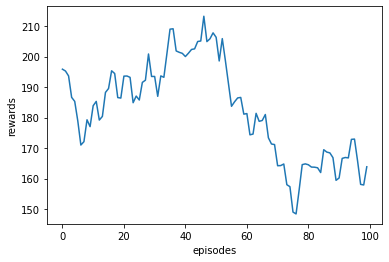



 20%|██        | 607/3000 [2:23:38<7:03:26, 10.62s/it]

1.047426945417714


KeyboardInterrupt: ignored

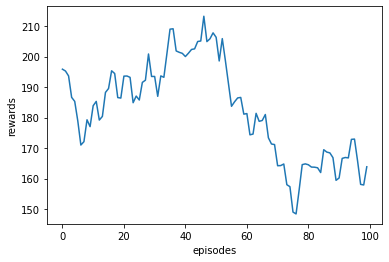

In [ ]:
env = FlexibleEnv()

for i_episode in tqdm(range(3000)):

  state, _ = env.reset()
  while np.abs(state[2]) < 0.6 or _: 
    state, _ = env.reset()

  print(state[2])
  total_reward = 0
  prev_action = None

  for steps in range(400):

    action = actor.choose_action(state)
    if prev_action is None: prev_action = action 
    next_state, contact = env.step([4*action])
    rew = reward(state, next_state, prev_action, action)

    done = 0
    if contact:
      rew = -10
      done = 1

    memory.add_transition(state, action, next_state, rew, done)

    total_reward += rew
    state = next_state
    prev_action = action

    if done: 
      print(steps)
      break

  if len(memory) > 2000: 
    for _ in range(200):   
      train_step()

  reward_list.append(total_reward)
  avg_rewards.append(np.mean(reward_list[-40:])) 

  plot(avg_rewards[-100:])


In [ ]:
env = FlexibleEnv()
actor.choose_action(state)

In [ ]:
save('bes332obs')

In [ ]:
from google.colab import files

In [ ]:
files.download('bes332obs')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.upload()

In [ ]:
state = torch.load('bes332obs', map_location = device)

In [ ]:
actor.load_state_dict(state['actor'])
critic.load_state_dict(state['critic'])
actor_optimizer.load_state_dict(state['actor_optimizer'])
critic_optimizer.load_state_dict(state['critic_optimizer'])

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

#Test Learned Policy

In [64]:
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

In [65]:
env = FlexibleEnv()
def Go_to(goal = np.pi/2, init_state = None):

  goal_state = 1
  goal = goal/np.pi

  env.start_recording(init_state)

  us = []

  for i in range(500):

      S,_ = env.get_state

      u = actor.choose_action(S, False)
      us.append(4*u)
      state = env.step([4*u])

  env.stop_recording()
  plt.plot([i*0.01 for i in range(len(us))], us)
  plt.xlabel('time')
  plt.ylabel('torque')
  plt.title(f'Torque vs Time')


  #Add target angle Marker in visualiser
  R = RollPitchYaw([np.pi/4, 0, 0])
  T = RigidTransform(R, [0.0625,0,0]).GetAsMatrix4()
  AddTriad(env.visualizer.vis, name='target', prefix='', length=0.25, radius=0.003, opacity=0.8)
  env.visualizer.vis['']['target'].set_transform(T)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6005...
You can open the visualizer by visiting the following URL:
http://4799dfddcd1e.ngrok.io/static/
Connected to meshcat-server.


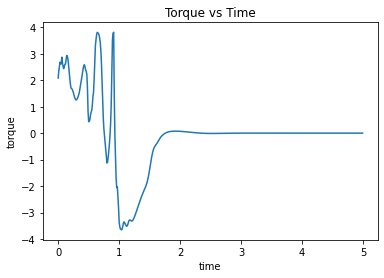

In [66]:
Go_to(0, [np.pi,0,0,0])

# env.get_state